In [2]:
import statsmodels.api as sm
import pandas as pd
import re,string
import nltk
from patsy import dmatrices
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import warnings
%pylab inline
import numpy as np
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv("edmunds_comments.csv",  encoding='utf-8')
df.head()

date      username  \
0  September 7       dino001   
1  September 7       circlew   
2  September 8       qbrozen   
3  September 9  FlightNurse2   
4  September 9    roadburner   

                                                post  \
0  If they keep it around in next four-five years...   
1  The lease rate is the factor that stops me col...   
2  circlew said:\nThe lease rate is the factor th...   
3  roadburner said:\nshow previous quotes\n\n\nTh...   
4  Again, the local dealer are hopeless at best(W...   

                                              quotes  
0  The lease rate is the factor that stops me col...  
1  show previous quotes\n\n\nThe Stinger is too b...  
2                                                NaN  
3  Again, the local dealer are hopeless at best(W...  
4  Thanks, but I am more than aware of the distin...

In [4]:
#clean punctuation and white spaces
df["post_clean"] = df.post.apply(lambda x:re.sub(r"[^a-zA-Z0-9\s]", " ", x.lower()))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r"\n", " ", x.lower()))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r'\s+', ' ', x))

In [5]:
#removing stop words
stop = set(stopwords.words('english'))
df['post_clean'] = df.post_clean.apply(lambda x: [word for word in x.split() if word not in stop])

In [6]:
df.head(20)

date       username  \
0    September 7        dino001   
1    September 7        circlew   
2    September 8        qbrozen   
3    September 9   FlightNurse2   
4    September 9     roadburner   
5    September 9   FlightNurse2   
6    September 9     roadburner   
7    September 9        dino001   
8   September 24     benjaminhf   
9   September 24       stickguy   
10  September 24          kyfdx   
11      August 7      benjaminh   
12      August 8        andres3   
13      August 8      benjaminh   
14      August 8            sda   
15      August 8         henryn   
16      August 8     roadburner   
17      August 8       Michaell   
18      August 8  Mr_Shiftright   
19      August 8       Michaell   

                                                 post  \
0   If they keep it around in next four-five years...   
1   The lease rate is the factor that stops me col...   
2   circlew said:\nThe lease rate is the factor th...   
3   roadburner said:\nshow previous quotes\n\n\nTh...   
4   Again, the local dealer are hopeless at best(W...   
5   roadburner said:\nAgain, the local dealer are ...   
6   Thanks, but I am more than aware of the distin...   
7   roadburner said:\nThanks, but I am more than a...   
8   I am the poster formerly known as benjaminh an...   
9   Still on the list. Just have not been looking ...   
10  benjaminhf said:\nI am the poster formerly kno...   
11  One of the features I like on my TLX's stereo ...   
12  benjaminh said:\nOne of the features I like on...   
13  andres3 said:\n....What's the storage capacity...   
14  benjaminh said:\nshow previous quotes\nGood qu...   
15  Back in the late 80's or early 90's (don't rem...   
16  The hard drives in late model BMWs have a 20GB...   
17  henryn said:\nBack in the late 80's or early 9...   
18  sda said:\nshow previous quotes\n\n\n\nThat's ...   
19  Mr_Shiftright said:\nshow previous quotes\n\n\...   

                                               quotes  \
0   The lease rate is the factor that stops me col...   
1   show previous quotes\n\n\nThe Stinger is too b...   
2                                                 NaN   
3   Again, the local dealer are hopeless at best(W...   
4   Thanks, but I am more than aware of the distin...   
5   I am the poster formerly known as benjaminh an...   
6          show previous quotes\nI sent you a message   
7                                                 NaN   
8   If I do manage to upgrade to a TLX it would ha...   
9   The fine lrint for all says "plus dealer add-o...   
10  The CTS looks like a smokin’n deal if your nam...   
11  One of the features I like on my TLX's stereo ...   
12  ....What's the storage capacity in GB? If unco...   
13  show previous quotes\nGood questions. Tried to...   
14                                                NaN   
15  Back in the late 80's or early 90's (don't rem...   
16  show previous quotes\n\n\n\nThat's cool as I s...   
17                                                NaN   
18                                                NaN   
19  show previous quotes\n\n\n\n\n\nFunny...I just...   

                                           post_clean  
0   [keep, around, next, four, five, years, think,...  
1   [lease, rate, factor, stops, cold, taking, lea...  
2   [circlew, said, lease, rate, factor, stops, co...  
3   [roadburner, said, show, previous, quotes, sti...  
4   [local, dealer, hopeless, best, put, ya, car, ...  
5   [roadburner, said, local, dealer, hopeless, be...  
6   [thanks, aware, distinction, dealer, group, ow...  
7   [roadburner, said, thanks, aware, distinction,...  
8   [poster, formerly, known, benjaminh, benjaminh...  
9             [still, list, looking, actively, right]  
10  [benjaminhf, said, poster, formerly, known, be...  
11  [one, features, like, tlx, stereo, built, memo...  
12  [benjaminh, said, one, features, like, tlx, st...  
13  [andres3, said, storage, capacity, gb, uncompr...  
14  [benjaminh, said, show, previous, qu

### Replacing model with make in the corpus

In [7]:
#importing model list
car_models = pd.read_csv("car_models_curated_V2.csv", )
car_models.head()
car_models.dtypes

make      object
model1    object
dtype: object

In [8]:
car_models["model1"]=car_models["model1"].astype(str)
car_models["make"] = car_models["make"].apply(lambda x:re.sub(r"[^\w\s]", "", x.lower()))
car_models["model1"] = car_models["model1"].map(lambda x:re.sub(r"[^\w\s]", "", x.lower()))

In [9]:
#converting into dictionary
#This will help in identifying make for corresponding model
car_dict = car_models.set_index('model1').transpose().to_dict()
model = "beetle"
car_dict[model]['make']

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  This is separate from the ipykernel package so we can avoid doing imports until


'volkswagen'

In [10]:
#replace model with make
model1 = set(car_models["model1"])
df["post_c2"] = df.post_clean.map(lambda x: [car_dict[i]['make'] if i in model1 else i for i in x])

In [11]:
#lemmatizing
#need to get POS for lemmatizing
#create a function that would return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
#wnl = WordNetLemmatizer()
#df['post_lema'] = df.post_clean.apply(lambda x: [wnl.lemmatize(word) for word in x])

### Checking frequency for all values

In [12]:
#getting frequency distribution
car_posts = df['post_c2'].sum()

In [13]:
all_words = nltk.FreqDist(car_posts)
rslt_all = pd.DataFrame.from_dict(all_words,orient='index').reset_index()
rslt_all.columns = ['word','frequency']

### Most popular brands (all)

In [14]:
rslt_all[rslt_all['word'].isin(car_models["make"])].nlargest(10,'frequency')

word  frequency
33          bmw        239
156       acura        208
212        audi        159
117     polaris        121
13          kia        111
209       honda        110
793  volkswagen         57
159       kymco         51
114     triumph         41
4          ford         39

### Taking unique values (using set)

In [15]:
cars_unique = df.post_c2.map(lambda x:[ "".join(word) for word in sorted(set(x))]).sum() 

In [16]:
unique_words = nltk.FreqDist(cars_unique)
rslt_unique = pd.DataFrame.from_dict(unique_words,orient='index').reset_index()
rslt_unique.columns = ['word','frequency']

### Most popular brands (unique)

In [17]:
rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(10,'frequency')

word  frequency
7           bmw        120
145       acura         83
111     polaris         79
197        audi         78
219       honda         57
33          kia         52
160       kymco         44
817  volkswagen         37
124     triumph         31
101   cub cadet         30

### Calculate Lift Ratio

Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on the Internet). 

In [29]:
def ratio(a, b):
    a = float(a)
    b = float(b)
    if b == 0:
        return a
    return ratio(b, a % b)

#returns a string with ratio
def get_ratio(a, b):
    r = ratio(a, b)
    return "%s" % float((a/r) / (b/r))

In [121]:
#selecting top brands
def create_mds(num_brands):
    top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
    car_make_df = pd.DataFrame()
    car_make_df['brand1'] = [x for x in top_brands.word for y in top_brands.word] #if x!=y]
    car_make_df['brand2'] = [y for x in top_brands.word for y in top_brands.word] #if x!=y]
    car_make_df['ratio'] = [get_ratio(x,y) for x in top_brands.frequency for y in top_brands.frequency] #if x!=y]
    xdf = car_make_df.pivot(index="brand1",columns="brand2",values="ratio")
    mds = MDS(n_components=2,random_state=6)
    similarities = euclidean_distances(xdf.values.astype(np.float32))
    res = mds.fit(xdf.values.astype(np.float64))
    return(xdf,res)   

In [101]:
def plot_mds(xdf,res):
    plt.figure(figsize=(12,8))
    plt.scatter(res.embedding_[:,0],res.embedding_[:, 1])

    #plot the brand name labels
    for label, x, y in zip(xdf.columns.values, res.embedding_[:, 0], res.embedding_[:, 1]):
        plt.annotate(label,xy = (x, y), xytext = (-20, 20),textcoords = 'offset points', ha = 'left', va = 'bottom',
                     bbox = dict(boxstyle = 'round,pad=.2', fc = 'orange', alpha = 0.6),
                     arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        plt.show()

### Insights

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


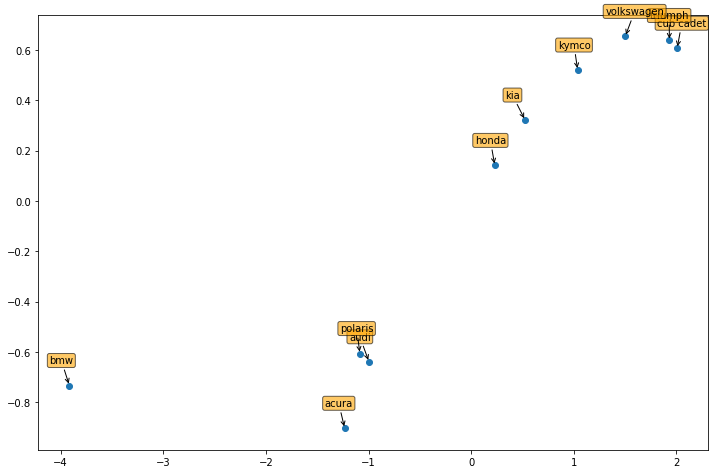

In [124]:
# plot MDS top 10
lift_df, results = create_mds(num_brands = 10)
plt_mds(lift_df, results)

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


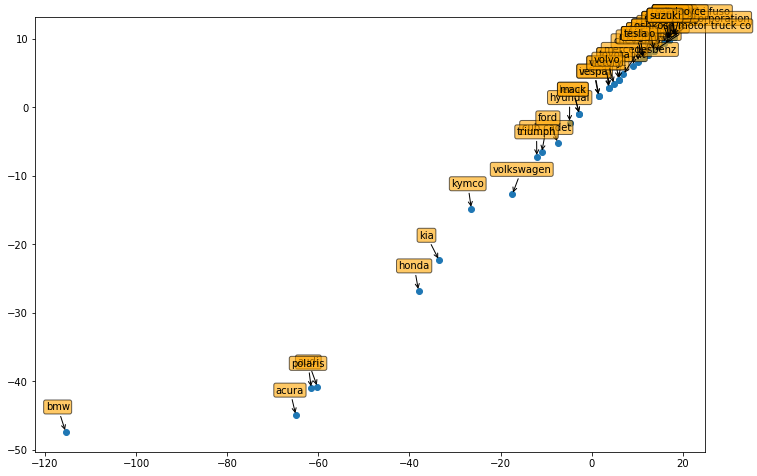

In [125]:
# plot MDS top 50
lift_df, results = create_mds(num_brands = 50)
plt_mds(lift_df, results)

### Frequently mentioned attributes for cars

Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? 

### While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on Edmunds? Show your analysis.   

### Advice to (i) product manager, and (ii) marketing/advertising manager of these brands based on attribute relations

### Most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?